# Experiment from July 2, 2015. Natural Scenes Analysis.
Structure of stimulus:  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
90 min natural scenes  
10 min of 1 min repeating natural scenes  
5 min high contrast white noise

In [19]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording
import pdb
import string
from jetpack.signals import peakdet
from scipy.signal import find_peaks_cwt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Choose data directory

In [20]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')

# Load photodiode  
To align stimulus and recording. The stimulus is briefly (<500ms) a grey screen, followed by a white photodiode for the first frame.

Chanlist flag not working as expected. Need to load whole array and just select first channel.

In [21]:
first_bin_file = data_dir + '150702a.bin'
header   = binary.readbinhdr(first_bin_file)
# header['fs']
# header['nsamples']
# raw_data = binary.readbin(first_bin_file)[:,0] # was real_data
# real_data.shape
raw_data = binary.readbin(first_bin_file, chanlist=[0])
# raw_data.shape
# len(raw_data)
# len(real_data)

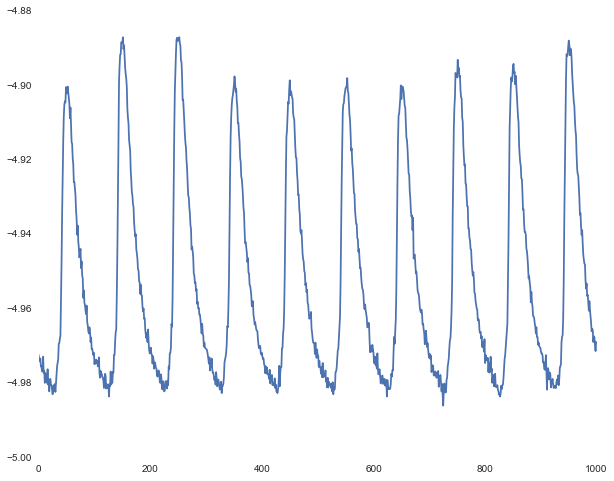

In [22]:
plot(raw_data[-1000:])
# plot(real_data[-1000:])

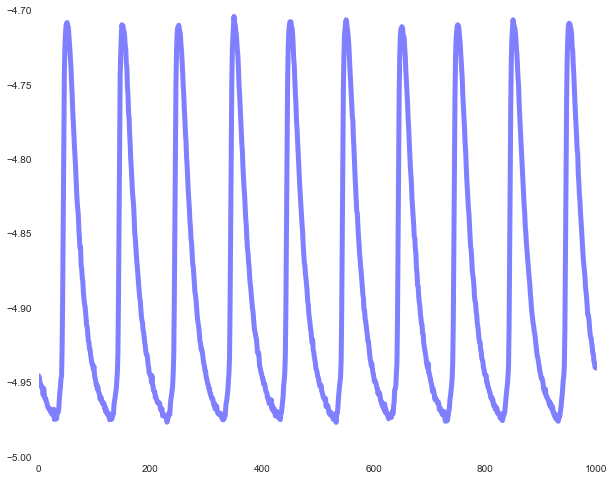

In [23]:
plot(raw_data[:1000], 'b', alpha=0.5, linewidth=5)
# plot(real_data[:1000], 'g.', alpha=0.5, markersize=20)

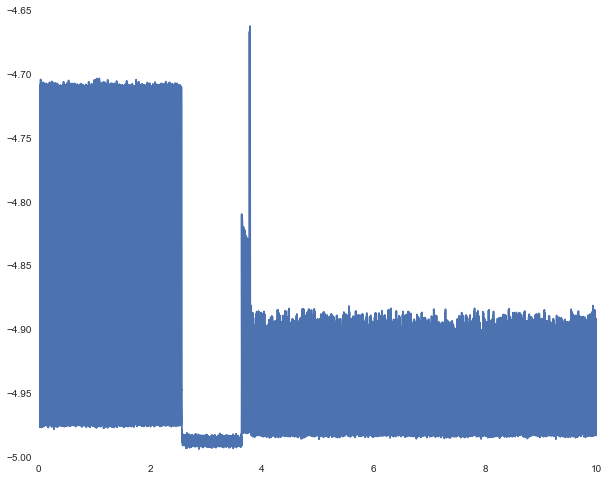

In [24]:
# show first 10 seconds
disp_frames = int(10 * header['fs'])
plot(np.linspace(0, 10, disp_frames), raw_data[:disp_frames])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


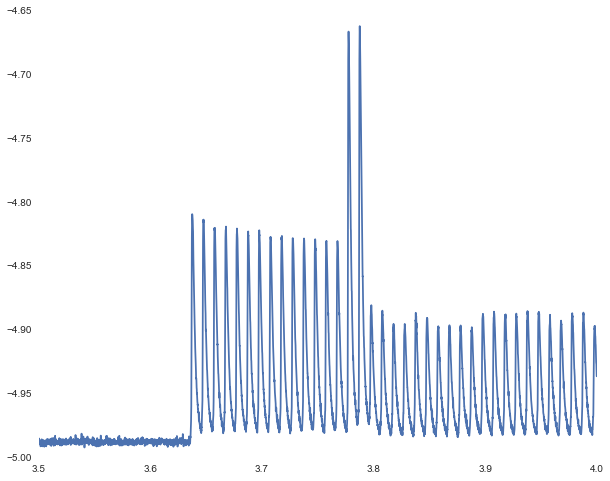

In [25]:
# show 3.5 to 4 seconds
disp_frames_start = 3.5 * header['fs']
disp_frames_end   = 4 * header['fs']
plot(np.linspace(3.5, 4, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


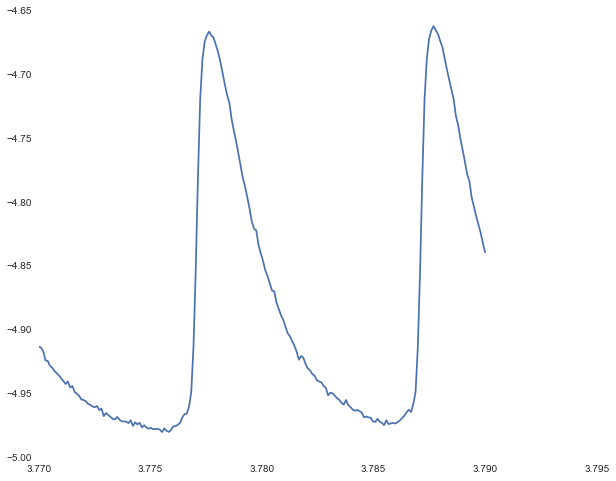

In [26]:
# show 3.77 to 3.79 seconds
disp_frames_start = 3.77 * header['fs']
disp_frames_end   = 3.79 * header['fs']
plot(np.linspace(3.77, 3.79, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

In [27]:
first_white_peak  = np.argmax(raw_data[3.77 * header['fs'] : 3.785 * header['fs']])
first_white_ind   = first_white_peak + 3.77 * header['fs']
time_stim_started = first_white_ind / header['fs']
print 'Stimulus started at %f seconds, relative to recording computer' %(time_stim_started)

Stimulus started at 3.777600 seconds, relative to recording computer


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


# Load spikes

In [28]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) - time_stim_started for spike in spikes if (not (not spike)) and float(spike) - time_stim_started > 0])
    
    text_file.close()

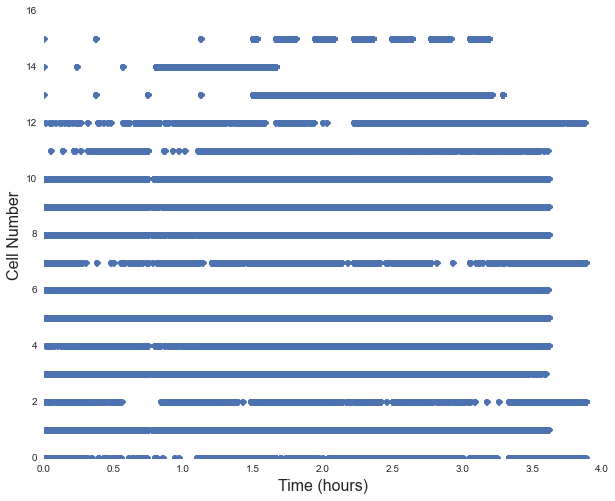

In [29]:
num_cells = len(cells)
all_spiking = np.hstack([ np.vstack((np.array(cell), np.ones(len(cell))*idx)) for idx, cell in enumerate(cells) ]).T
all_spiking.shape

plot(all_spiking[:,0]/(3600.), all_spiking[:,1], 'o')
xlabel('Time (hours)', fontsize=16)
ylabel('Cell Number', fontsize=16)

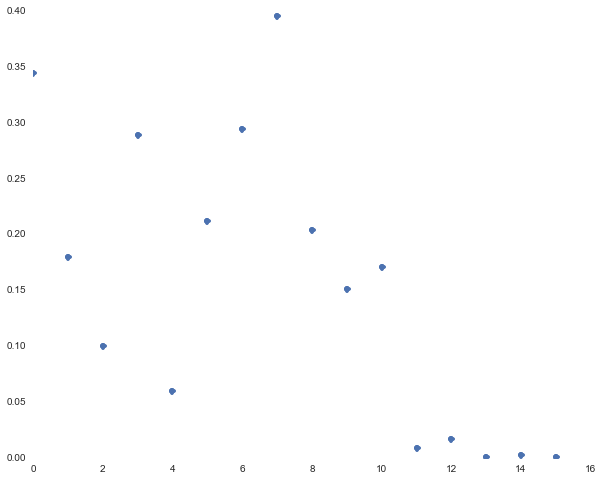

In [30]:
avg_spike_rate = [len(np.array(cells[i])[np.array(cells[i]) < 22.5*60.])/(22.5*60.) for i in range(len(cells))]
plot(avg_spike_rate, 'o')

# Reconstruct natural scenes stimulus  
To naively reconstruct the stimulus frame-by-frame would be >70 GB, so instead we're just going to store the jitter, centers, and image indices.  

Expt5 is natural scenes.  
Expt6 through Expt15 are repeats of the first 1 min of the natural scenes stimulus.  

The HDF5 file in expt5/stim is (nframes, 3) array where dimensions are (image index, xstart, ystart), respectively.

## Load data

In [31]:
stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/natural_scenes_stimulus_norepeats.h5')
f = h5py.File(stim_file)

In [32]:
f.keys()

[u'expt5', u'images']

In [33]:
f['expt5'].keys()

[u'stim', u'timestamps']

#### why are some of the images the same?

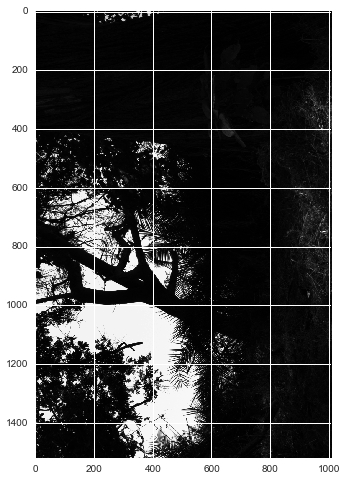

In [34]:
imshow(f['images'][0])

In [35]:
np.max(f['expt5/timestamps'])

5508.4455000000307

In [36]:
np.max(all_spiking)

13995.6787

In [37]:
from __future__ import division
def rescale(x):    
    # note that if python3 division isn't being used, integers will be truncated
    xmin = np.min(x)
    xmax = np.max(x)
    return (x - xmin) / (xmax - xmin)

class NaturalScenesStimulus(object):
    '''Take the compressed natural scenes data and return the appropriate frame(s).'''

    def __init__(self, images, stimulus):
        '''Images should be (num_images, height, width).
        Stimulus should be (num_frames, 3) where the three
        dimensions refer to image index, xstart, ystart.'''
        self.images = images
        self.stimulus = stimulus
        self.ndims = 500

    def __getitem__(self, index):
        #pdb.set_trace()
        img_index = self.stimulus[index, 0].astype('int')
        xstart = self.stimulus[index, 1].astype('int')
        ystart = self.stimulus[index, 2].astype('int')
        # Need to check if index is integer or iterable
        try:
            # assume index is a slice
            imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
            return np.array([2*img[y:y+self.ndims, x:x+self.ndims] for x,y,img in zip(xstart,ystart,imgs)])
        except:
            # otherwise index is an integer
            img = rescale(self.images[img_index])
            return img[ystart:ystart+self.ndims, xstart:xstart+self.ndims]

In [38]:
natural_stimuli = NaturalScenesStimulus(f['images'], f['expt5/stim'])

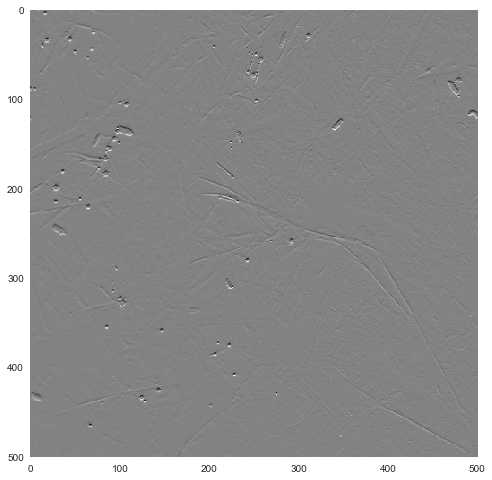

In [39]:
imshow(natural_stimuli[1:5][1] - natural_stimuli[1:5][0])
plt.grid(False)

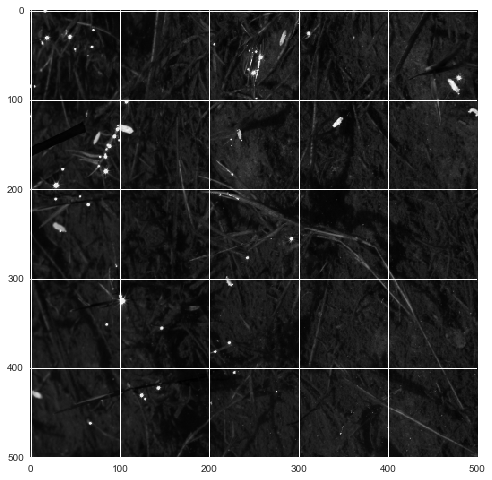

In [40]:
imshow(natural_stimuli[0])

# Load repeats

In [41]:
stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/natural_scenes_stimulus_repeats.h5')
g = h5py.File(stim_file)

In [42]:
g.keys()

[u'expt10',
 u'expt11',
 u'expt12',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt6',
 u'expt7',
 u'expt8',
 u'expt9']

In [43]:
g['expt10'].keys()

[u'stim', u'timestamps']

# Load photodiode white frames

In [44]:
white_frames = np.loadtxt(data_dir + 'photodiode_white_frame_timestamps.txt')

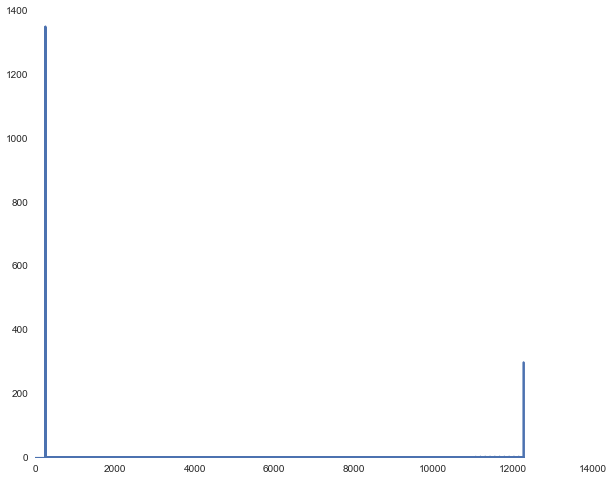

In [45]:
plot(np.diff(white_frames))

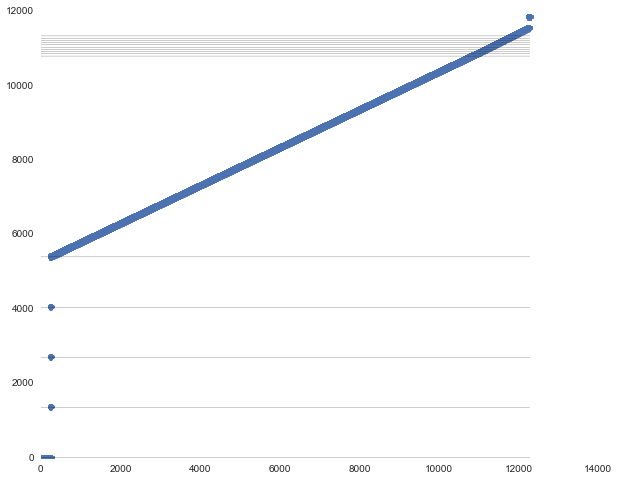

In [46]:
plot(white_frames, 'o')
# expt1
plot(0*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt2
plot(60*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt3
plot(60*2*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt4
plot(60*3*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt5
plot(60*4*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt6 to expt15
for expt in range(10):
    plot(60*(4*22.5+90+expt)*np.ones(len(white_frames)),'k', linewidth=0.2)
# tmp = plt.xlim([-100, len(white_frames)])
# tmp = plt.ylim([-100, np.max(white_frames)])
# mpld3.display()

In [47]:
print 'The white frames stretch to about %d seconds, or %f hours. Experiment was 3.25 hours.' %(white_frames[-1], white_frames[-1]/3600.) 

The white frames stretch to about 11859 seconds, or 3.294246 hours. Experiment was 3.25 hours.


#### Naively we expect the repeating natural scenes trials to start at 10800 seconds (90 minutes of low/high/low/high white noise, followed by 90 minutes continuous non-repeating natural scenes). But this is not the case.  

#### We will use the white frames detected from the photodiode to properly align it. Although natural scenes set the photodiode to white every time the image flips (which in this case is about 1 Hz), there is a lag during which the natural images are loaded at the beginning of every trial. We can use this lag to detect when each trial starts.

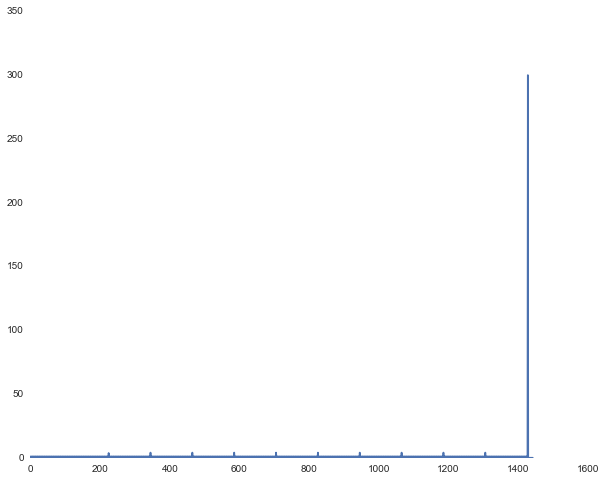

In [48]:
wiggle_room = 500. #180.
naive_start = 10800.
naive_end = naive_start + 10.*60. + wiggle_room
plot(np.diff(white_frames[np.bitwise_and(white_frames > naive_start, white_frames < naive_end)]))
naive_repeats_range = np.bitwise_and(white_frames > naive_start, white_frames < naive_end)
# mpld3.display()

In [49]:
trial_breaks = white_frames[naive_repeats_range][np.diff(white_frames[naive_repeats_range]) > 2]
trial_starts = trial_breaks[:-1]
trial_ends = trial_breaks[1:]

In [50]:
trial_starts

array([ 10915.2452,  10979.25  ,  11043.565 ,  11107.8802,  11172.2051,
        11236.5202,  11300.8352,  11365.1502,  11429.4653,  11493.7802])

In [51]:
trial_ends

array([ 10979.25  ,  11043.565 ,  11107.8802,  11172.2051,  11236.5202,
        11300.8352,  11365.1502,  11429.4653,  11493.7802,  11559.1159])

In [52]:
trial_ends - trial_starts

array([ 64.0048,  64.315 ,  64.3152,  64.3249,  64.3151,  64.315 ,
        64.315 ,  64.3151,  64.3149,  65.3357])

In [53]:
print 'Total time of repeating of natural scenes is %f minutes. Should be around 10 min.' %((trial_ends[-1]-trial_starts[0])/60.)

Total time of repeating of natural scenes is 10.731178 minutes. Should be around 10 min.


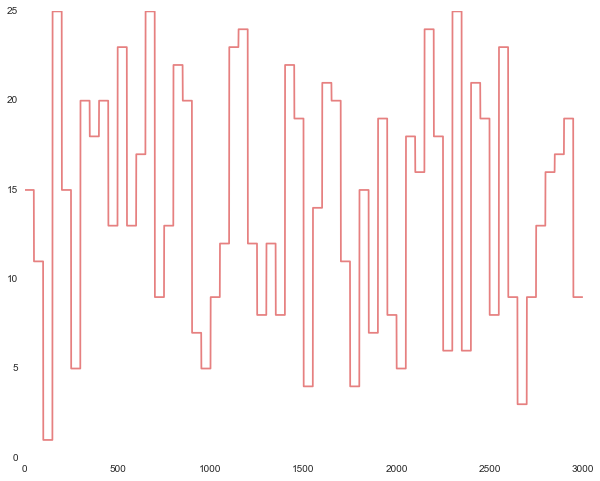

In [54]:
plot(g['expt7/stim'][:,0], color=(0.9,.5,.5))

(-1, 62)

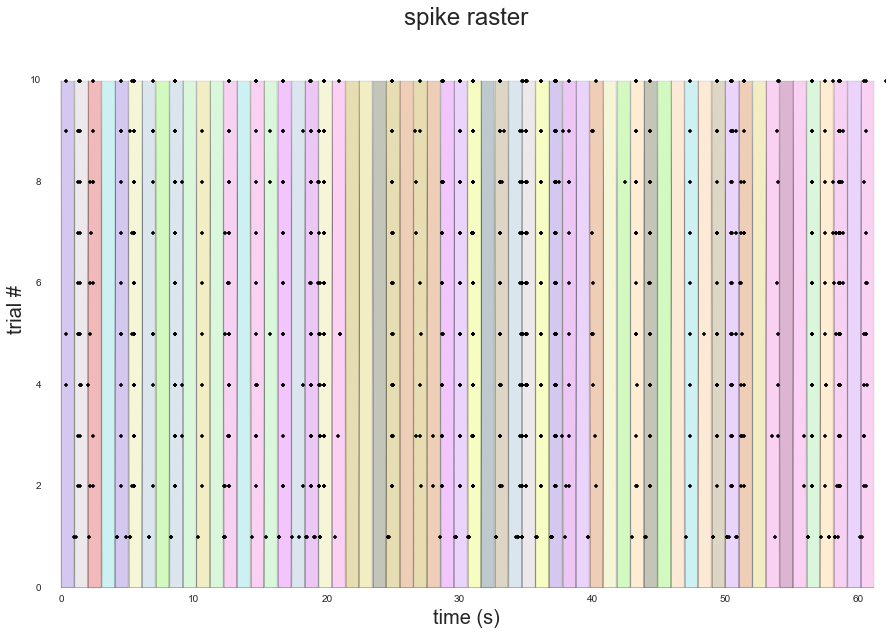

In [55]:
# 4 periods of white noise, then 90 min of natural scenes without repeats, 
# then 1 min repeats of natural scenes for 10 min
cell_idx = 5
num_trials = 10
# relevant_spikes = np.array(cells[cell_idx]) - trial_starts[0]
# relevant_spikes = relevant_spikes[relevant_spikes > 0]
# relevant_spikes = relevant_spikes[relevant_spikes <= np.sum(np.diff(trial_starts)) + np.mean(np.diff(trial_starts))]

# spikes = relevant_spikes
# trial_length=length_of_each_trial #+ 3.1

spikes = np.array(cells[cell_idx])

# Plot each trial
fig = plt.gcf()
fig.set_size_inches((15,10))
ax = fig.add_subplot(111)
for trial in range(num_trials):
    # Compute the time indices of each trial
    idx = np.bitwise_and(spikes > trial_starts[trial], spikes <= trial_ends[trial])
    ax.plot(spikes[idx] - trial_starts[trial], (trial + 1) * np.ones((idx.sum(), 1)),
            color='k', linestyle='none', marker='.')
    
# plot when image changes
# plot(g['expt7/timestamps'], (num_trials/25.)*g['expt7/stim'][:,0], 'k', linewidth=0.5)
change_images = num_trials*np.sign(np.abs(np.diff(g['expt7/stim'][:,0])))
change_images = np.insert(change_images, 0, num_trials)
colors = {}
# make a random RGB color for each image
for image_ind in np.unique(g['expt7/stim'][:,0]):
    colors[image_ind] = (np.random.rand(1), np.random.rand(1), np.random.rand(1)) 
    ax.fill_between(g['expt7/timestamps'], 0, num_trials, where=(g['expt7/stim'][:,0]==image_ind),
                    facecolor=colors[image_ind], alpha=0.3)

# change_inds = np.argwhere(change_images > num_trials-1)
# for start_ind in change_inds:
#     ax.fill_between(g['expt7/timestamps'], 0, num_trials, where=(g['expt7
    
    
# plot vertical lines when each image changes
ax.plot(g['expt7/timestamps'], change_images, 'k', linewidth=0.2)


# Labels, etc.
plt.title('spike raster', fontdict={'fontsize': 24})
plt.xlabel('time (s)', fontdict={'fontsize': 20})
plt.ylabel('trial #', fontdict={'fontsize': 20})
plt.ylim(ymin=0, ymax=num_trials+1)
plt.xlim([-1, 62])

# resolution = 1000
# new_images = np.zeros((60*resolution,))
# new_images[::resolution] = 1
# ax.plot(np.linspace(0,60.,60*resolution), 10.1 * new_images, 'k', linewidth=0.2)

# See whether you can get a nice STA from the last white noise sequence (after the natural scenes)

In [56]:
last_stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/stimulus_last_white_noise.h5')
l = h5py.File(last_stim_file)

In [57]:
l['expt16'].keys()

[u'stim', u'timestamps']

In [58]:
l['expt16/timestamps'][:10]

array([ 0.    ,  0.0201,  0.0401,  0.0601,  0.0801,  0.1001,  0.1201,
        0.1401,  0.1601,  0.1802])

In [59]:
last_stimulus = np.array(l['expt16/stim']).T
last_stimulus.shape

(32, 32, 14991)

Align to the photodiode

In [60]:
trial_ends[-1]

11559.115900000001

In [61]:
last_start = trial_ends[-1]
last_end = last_start + l['expt16/timestamps'][-1]
last_stim_time = np.linspace(last_start, last_end, last_stimulus.shape[2])

Choose a cell

In [62]:
letter = 'm'
bin_filename = '%s%s.bin' %(experiment_date, letter)
bin_file = data_dir + bin_filename
raw_data = binary.readbin(bin_file, chanlist=[0])

In [63]:
len(raw_data)

10000000

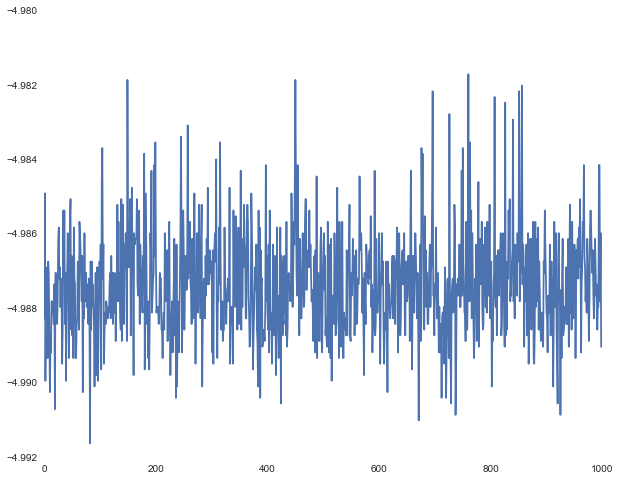

In [64]:
plot(raw_data[:1000])

In [65]:
cell_idx = 6

In [66]:
last_spikes = cells[cell_idx]
sta, tax = pyret.filtertools.getsta(last_stim_time, last_stimulus, last_spikes, 1000)

In [67]:
sta.shape

(32, 32, 1000)

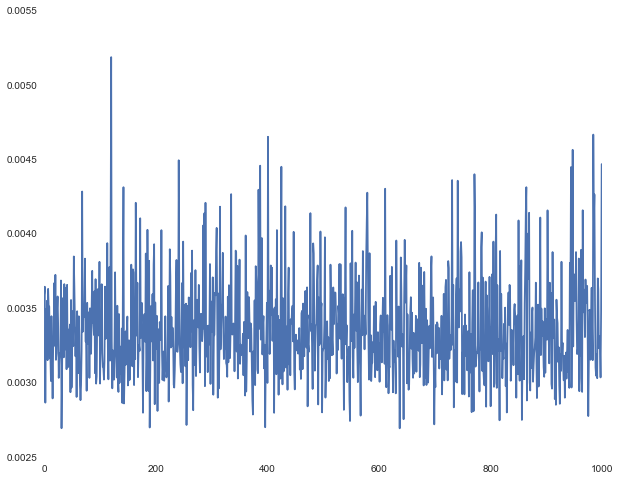

In [68]:
plot([np.max(np.abs(sta[:,:,i])) for i in range(sta.shape[-1])])

In [626]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

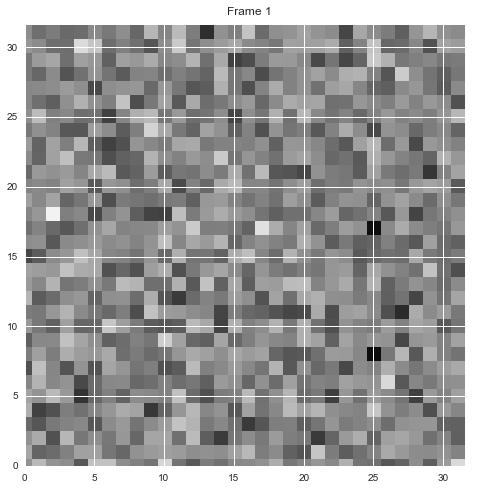

In [590]:
anim = pyret.visualizations.playsta(sta, clim=[np.min(sta), np.max(sta)])
display_animation(anim)

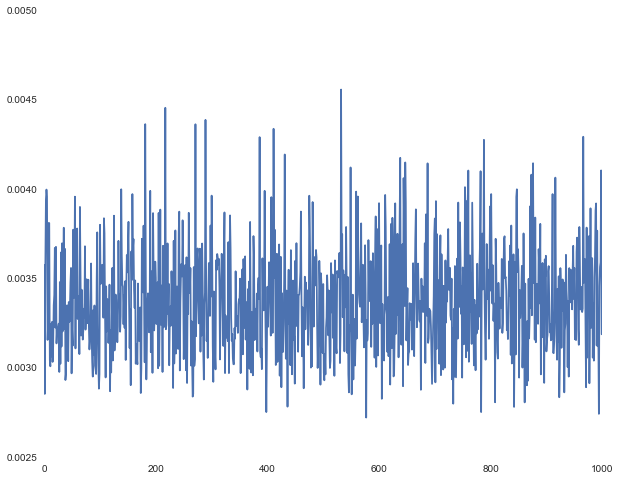

In [454]:
plot([np.max(abs(sta[:,:,i])) for i in range(sta.shape[-1])])

# Other than the first white noise frame, the photodiode should be a scaled top left pixel. Should do an autocorrelation to determine timing.

Photodiode is 10,000 Hz, stimulus is 50 Hz. So should subsample photodiode by a factor of 10,000/50 = 200.

In [12]:
# import time
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')
experiment_date = '150702'
white_threshold = -4.7
num_bin_files = 14
bin_file_suffices = string.ascii_lowercase[:num_bin_files]
fs = 10000.0 # Hz
stim_fs = 50.0
subsample_rate = int(fs/stim_fs)
bin_file_duration = 1000.0 # seconds

# store timestamps of each white frame
subsampled = []

# for each bin file
for idl, letter in enumerate(['a']): #enumerate(bin_file_suffices):
    # load bin files
    bin_filename = '%s%s.bin' %(experiment_date, letter)
    bin_file = data_dir + bin_filename
    raw_data = binary.readbin(bin_file, chanlist=[0])
    
    subsampled.append(raw_data[::subsample_rate])

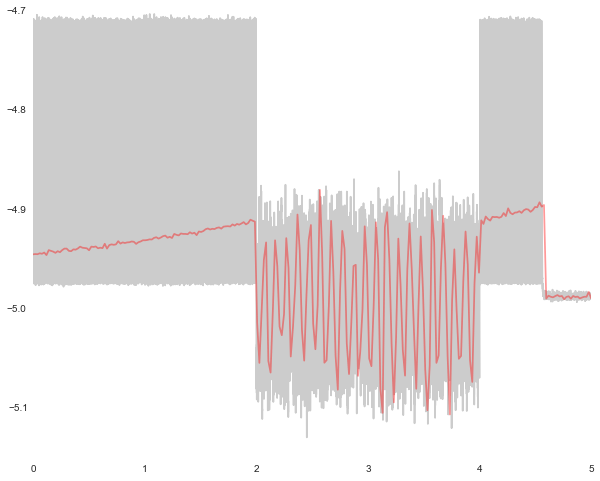

In [456]:
# plot first 5 seconds
subsampled_view_length = int(5*stim_fs)
raw_view_length = int(5*fs)
plot(np.linspace(0,5,raw_view_length), raw_data[:raw_view_length], 'k', alpha=0.2)
plot(np.linspace(0,5,subsampled_view_length), subsampled[0][:subsampled_view_length], 'r', alpha=0.4)

Problem is that monitor refresh isn't exactly 50 Hz.

In [457]:
len(raw_data)

10000000

In [458]:
? np.insert

In [459]:
filt = np.ones((10,))
filt = np.insert(filt, 0, np.zeros((5,)))
filt = np.append(filt, np.zeros((5,)))
filt /= np.sum(filt)

In [460]:
tmp = np.convolve(raw_data[5000000-1000:5000000].squeeze(), filt, mode='same')
plot((tmp[10:-10] - np.mean(tmp[10:-10]))/np.std(tmp[10:-10] - np.mean(tmp[10:-10])))
plot(np.diff(tmp[10:-10])/np.std(np.diff(tmp[10:-10])))
mpld3.display()

In [461]:
raw_data[5000000-1000:5000000].shape

(1000, 1)

In [462]:
np.ones((5,1)).shape

(5, 1)

In [463]:
tmp_no_edges = tmp[10:-10]
peakinds = find_peaks_cwt(tmp_no_edges, np.arange(1,50))
# peakinds = find_peaks_cwt(testing, np.arange(1,50))

In [464]:
peakinds

[143, 300, 407, 499, 539, 669, 837]

In [465]:
tmp_no_edges[peakinds[0]]

-4.902008056640625

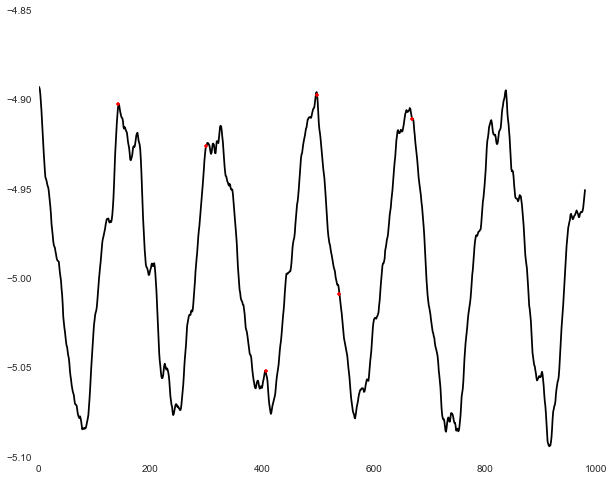

In [466]:
plot(tmp_no_edges, 'k')
plot(peakinds[:-1], tmp_no_edges[peakinds[:-1]], 'r.')

In [467]:
np.diff(peakinds)

array([157, 107,  92,  40, 130, 168])

In [468]:
tmp_no_edges[peakinds[0]::100]

array([-4.90200806, -5.0738678 , -4.947052  , -4.99958801, -5.01899719,
       -4.91711426, -5.0774231 , -4.9168396 , -4.99824524])

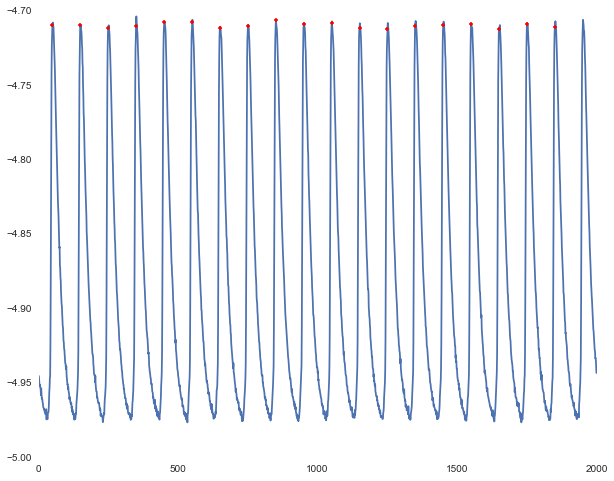

In [469]:
raw_peakinds = find_peaks_cwt(raw_data[:2000].squeeze(), np.arange(1,100))
plot(raw_data[:2000])
plot(raw_peakinds, raw_data[raw_peakinds], 'r.')

In [470]:
np.diff(raw_peakinds)

array([100, 100, 100, 101, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100])

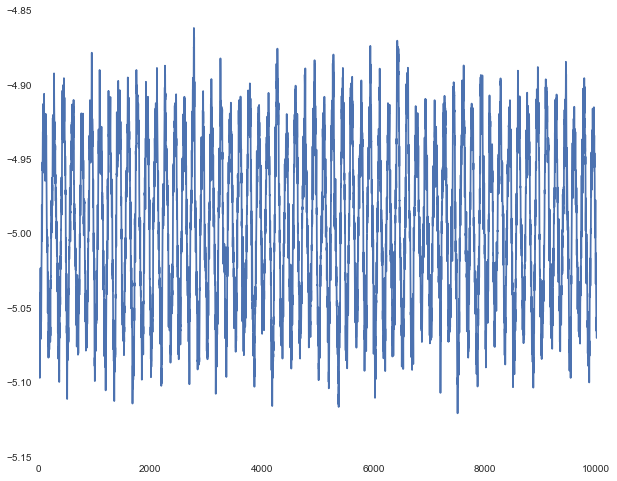

In [471]:
plot(raw_data[30000:40000])

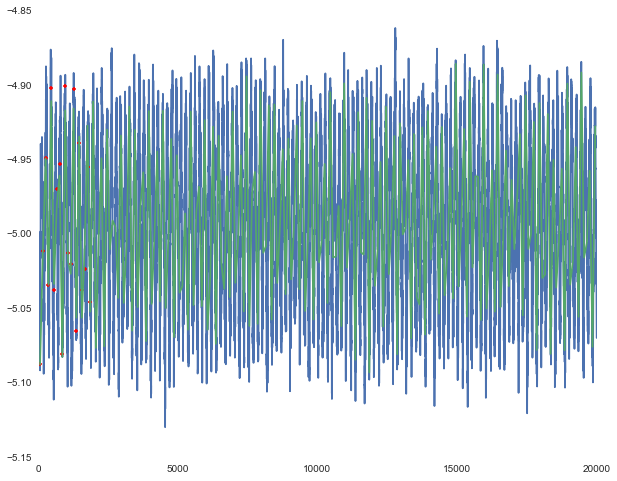

In [472]:
#raw_peakinds = find_peaks_cwt(raw_data[20000:40000].squeeze(), np.arange(1,100))
plot(raw_data[20000:40000])
plot(raw_peakinds, raw_data[20000:40000][raw_peakinds], 'r.')
plot(np.arange(40000-20000)[raw_peakinds[0]::100], raw_data[20000:40000][raw_peakinds[0]::100])
# mpld3.display()

In [473]:
np.diff(raw_peakinds)

array([100, 100, 100, 101, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100])

In [474]:
raw_sample = raw_data[20000:40000]
all_frame_timestamps = []
all_frame_inds = []
all_frame_values = []

all_threshold = -4.92
bin_file_duration = 500.0
idl = 0
indices_passing_thresh = np.argwhere(raw_sample > all_threshold)[:,0]
if len(indices_passing_thresh) > 0:
    start_of_all_frame = [indices_passing_thresh[0]]
    end_of_all_frame = []
    for idd, d in enumerate(np.diff(indices_passing_thresh)):
        if d > 1:
            start_of_all_frame.append(indices_passing_thresh[idd+1])
            end_of_all_frame.append(indices_passing_thresh[idd])
    end_of_all_frame.append(indices_passing_thresh[-1])
    if len(start_of_all_frame) != len(end_of_all_frame):
        raise Exception('Have %d starts but %d ends to local maxima.' \
                %(len(start_of_all_frame), len(end_of_all_frame)))

    for start, end in zip(start_of_all_frame, end_of_all_frame):
        if end - start == 0:
            peak_ind = start
        else:
            snippet = raw_sample[start:end]
            try:
                peak_ind = start + np.argmax(snippet)
            except:
                import pdb
                pdb.set_trace()
        # append time in current file + time that was in previous bin files
        #print (letter, (peak/fs + idl*bin_file_duration)/60., (peak/fs + idl*bin_file_duration)/3600.)
        #fig = plt.gcf()
        #ax = plot(raw_data[start-10000:start+10000])
        #plt.show()
        #time.sleep(2)

        all_frame_timestamps.append(peak_ind/fs + idl*bin_file_duration)
        all_frame_inds.append(peak_ind)
        all_frame_values.append(raw_sample[peak_ind])

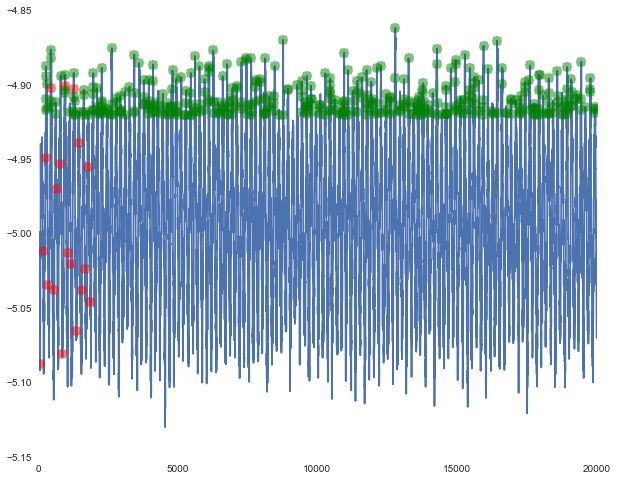

In [475]:
#raw_peakinds = find_peaks_cwt(raw_data[20000:40000].squeeze(), np.arange(1,100))
plot(raw_sample)
plot(raw_peakinds, raw_sample[raw_peakinds], 'r.', alpha=0.5, markersize=20)
plot(all_frame_inds, all_frame_values, 'g.', alpha=0.5, markersize=20)
# mpld3.display()

In [476]:
np.diff(all_frame_inds)

array([  5,  10,   4,  11,   6, 138,  16,   7,   6, 148,   5, 171, 145,
        13,  12, 160, 134,   6,  27,   3,   7,   6, 148, 147,   7,  14,
         5, 152,  15, 154,   9,   7,   5,   5, 126,   6,  12,  14, 136,
        10,   4,   3,   3,   5,   3, 160,  11,   6, 130,  25,   5,   5,
       153,  10,   3, 127,  24,   5,   4,   3, 140,  26, 131, 165,   2,
         7,  17, 149, 163,   8,   9,  11, 143,   7,   3,   8,   5,   3,
       144,  11,   5,   2,   7, 134,   4,  25, 148,   8,  10, 134,  22,
         8,  10, 124,  10,  12,  10,  14, 125,  12,  13,   9,   7, 151,
       139,   9,  10,  12, 135,  18,  15,   7,   2, 131,   3,   5,  21,
       143,   9,   7, 155,  11,   6, 139,   8,   9,   9,   4, 135,  34,
         3, 125,  13,   8,  19, 129,   7,  20,  12, 132,  11,   3,   7,
         5, 143,   9,   5,   5,   9, 134,   8,  12, 149,  11,  24, 133,
         9,  13,  18, 134,   3,  10,  12,  17, 122,   5,  11,   7, 144,
         9,  17, 132,   3,   5,   3,   2,  17, 131,  14,   5, 15

# Load frames from the entire photodiode trace (ran offline)

In [488]:
load_filename = data_dir + '%s_photodiode_all_frames_subsampled.hdf5' %(experiment_date)

In [489]:
subsampled_photodiode_file = h5py.File(load_filename)

In [490]:
subsampled_photodiode_file.keys()

[u'file_index', u'indices', u'timestamps', u'values']

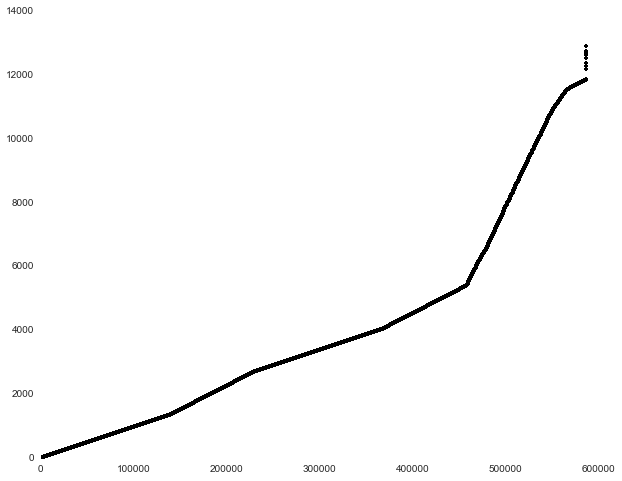

In [491]:
plot(subsampled_photodiode_file['timestamps'], 'k.')

In [492]:
subsampled_photodiode_file['file_index'][:200]

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a

In [493]:
subsampled_photodiode_file.close()

In [483]:
len(raw_sample)

20000